In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import random_split
from torch.nn.functional import relu
import warnings
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as plt_Polygon
import json
from PIL import Image
from shapely.geometry import Polygon, MultiPolygon
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tqdm as tqdm
from skimage import draw
from lightning.pytorch import loggers as pl_loggers

warnings.filterwarnings("ignore", category=UserWarning)

Отображение bbox на изображении

(971, 1260, 3)


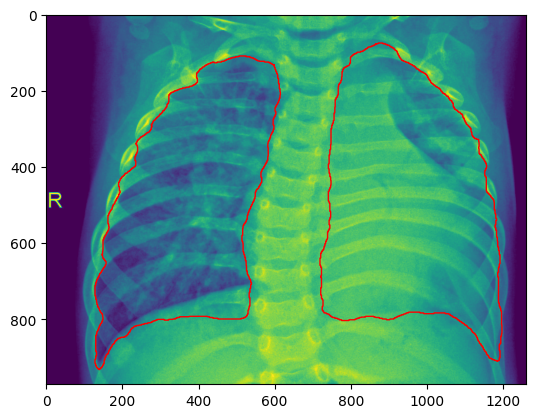

In [9]:
file_path = '../data/all-images/annotations/person802_bacteria_2708.json'  
with open(file_path, 'r') as json_file:
    data = json.load(json_file)

left_lung_x_coordinates = [point['x'] for point in data['annotations'][0]['polygon']['path']]
left_lung_y_coordinates = [point['y'] for point in data['annotations'][0]['polygon']['path']]

right_lung_x_coordinates = [point['x'] for point in data['annotations'][1]['polygon']['path']]
right_lung_y_coordinates = [point['y'] for point in data['annotations'][1]['polygon']['path']]

left_polygon = Polygon(zip(left_lung_x_coordinates, left_lung_y_coordinates))
right_polygon = Polygon(zip(right_lung_x_coordinates, right_lung_y_coordinates))


img = cv2.imread('../data/images/person802_bacteria_2708.jpeg')
print(img.shape)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(gray)
x, y = left_polygon.exterior.xy
plt.plot(x, y, color='r', linewidth=1)


x, y = right_polygon.exterior.xy
plt.plot(x, y, color='r', linewidth=1)

Оставляем только маски и изображения с сегментированными легкими 'name'= 'Lung'

Удаленные маски:
1) Снимки КТ, 'name' = 'CT'
2) Боковые рентгеновские снимки, 'name' = 'X-Ray'
3) Снимки с несколькими разметками

In [18]:
annotations_path = '../data/all-images/annotations/'
images_path = '../data/images'
lung_annotations_filename = []
lung_images_filename = []
annotations = os.listdir(annotations_path)
for ann in annotations:
    with open(annotations_path + ann, 'r') as json_file:
        data = json.load(json_file)
    if 'Lung' in data['annotations'][0]['name'] and 'Lung' in data['annotations'][1]['name'] :
        lung_annotations_filename.append(ann)
        lung_images_filename.append(data['image']['original_filename'])
        
print(f'Кол-во подходящих снимков - {len(lung_annotations_filename)} из {len(annotations)}')

Кол-во подходящих снимков - 6365 из 6365


In [19]:
def delete_extra_files():
    """
    Delete files with inappropriate format
    """
    img_path = '../data/images/'
    images_names = os.listdir(img_path)
    print(f'Начальное число изображений - {len(images_names)}')
    for name in images_names:
        if name not in lung_images_filename:
            full_path = os.path.join(img_path, name)
            os.remove(full_path) 
    
    print(f'Конечное число изображений - {len(images_names)}')
    
    ann_path = '../data/all-images/annotations/'
    annotations_names = os.listdir(ann_path)
    print(f'Начальное число json файлов - {len(annotations_names)}')
    for name in annotations_names:
        if name not in lung_annotations_filename:
            full_path = os.path.join(ann_path, name)
            os.remove(full_path)
            
    images_name = [img.split('.')[0] for img in lung_images_filename]
    images_format = [img.split('.')[1] for img in lung_images_filename]
    ann_name = [ann.split('.')[0] for ann in lung_annotations_filename]
    extra_images = set(images_name)  - set(ann_name)
    for name in extra_images:
        images = []
        if name in lung_images_filename:
            images.append(file_name)
        images_format = [img.split('.')[1] for img in images]
        file_name = name.split('.')[0] + '.json'
        full_path = os.path.join(img_path, name)
        os.remove(full_path)
    
    print(f'Конечное число json файлов - {len(os.listdir(ann_path))}')

delete_extra_files()

Начальное число изображений - 6365
Конечное число изображений - 6365
Начальное число json файлов - 6365
Конечное число json файлов - 6365


Класс для обработки сегментаций

In [17]:
class get_DataSet(Dataset):
    """
    class for preparing annotations
    """
    def __init__(self, path_to_imgs, path_to_json):
        self.path_to_imgs = path_to_imgs
        self.path_to_json = path_to_json
        self.img_ids = os.listdir(path_to_imgs)
    
    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        img_id = os.path.splitext(image_name)[0]
        img_format = os.path.splitext(self.img_ids[idx])[1]
        img = cv2.imread(os.path.join(self.path_to_imgs, img_id + img_format))
        load_json = json.load(open(os.path.join(self.path_to_json, img_id + ".json")))
        left_lung = [[point['x'], point['y']] for point in load_json['annotations'][0]['polygon']['path']]
        right_lung = [[point['x'], point['y']] for point in load_json['annotations'][1]['polygon']['path']]
        lungs = {'left_lung': left_lung,
                 'right_lung': right_lung}
        return img, lungs, image_name

    def __len__(self):
        return len(self.img_ids)
    

In [ ]:
image_path = '../data/images/'
annotations_path = '../data/all-images/annotations/'
dataset = get_DataSet(image_path, annotations_path)

In [15]:
def save_masks():
    for num in range(len(dataset)):
        img, lungs, img_name = dataset[num]
        left_polygon, right_polygon  = lungs['left_lung'], lungs['right_lung']
        left_mask = draw.polygon2mask(img.shape, left_polygon)
        right_mask = draw.polygon2mask(img.shape, right_polygon)
        combined_mask = left_mask + right_mask
        rotated_mask = np.rot90(np.fliplr(combined_mask), k=1)
        binary_image = rotated_mask.astype("uint8") * 255
        cv2.imwrite(f'../data/generated/_{img_name}', binary_image)

save_masks()

Создаем Датафрейм с путями до изображений и масок

In [10]:
img_folder = '../data/generated/resized_images'
mask_folder = '../data/generated/masks'
image_paths = []
mask_paths = []

for img_name, mask_name in zip(os.listdir(img_folder), os.listdir(mask_folder)):
    image_path = os.path.join(img_folder, img_name)
    image_paths.append(image_path)
    mask_path = os.path.join(mask_folder, mask_name)
    mask_paths.append(mask_path)

df = pd.DataFrame({'image_path': image_paths,
                  'mask_path' : mask_paths})



Разделяем на train/test/validation и сохраняем отдельными файлами 

In [39]:
objects = df['image_path']
labels = df['mask_path']
x, x_test, y, y_test = train_test_split(objects, labels, test_size=0.2, train_size=0.8, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.25, train_size =0.75, random_state=42)
train_df = pd.DataFrame({'object' : x_train,
                         'label' : y_train})
train_df.to_csv('../data/generated/train_df.csv', index=False)

test_df = pd.DataFrame({'object' : x_test,
                         'label' : y_test})
test_df.to_csv('../data/generated/test_df.csv', index=False)

val_df = pd.DataFrame({'object' : x_val,
                         'label' : y_val})
val_df.to_csv('../data/generated/val_df.csv', index=False)

In [92]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]  
        mask_path = self.dataframe.iloc[idx, 1] 

        img = Image.open(str(img_path)).convert('RGB')
        mask = Image.open(str(mask_path)).convert('L')

        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        return img, mask


class CustomDataset_with_Conturs(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]  
        mask_path = self.dataframe.iloc[idx, 1] 
        conturs_path = self.dataframe.iloc[idx, 2]

        img = Image.open(str(img_path)).convert('RGB')
        mask = Image.open(str(mask_path)).convert('L')
        conturs = Image.open(str(conturs_path)).convert('L')
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
            conturs = self.transform(conturs)
        target = torch.cat([mask, conturs], dim=0)
        # target = target.squeeze(1)
        return img, target
        

class UnetDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str):
        super().__init__()
        self.data_dir = data_dir
        self.transform = transforms.Compose([transforms.Resize((576, 576)), transforms.ToTensor()])
        self.batch_size = 4
    
    def setup(self, stage: str, conturs=False):
        if stage == "fit" or stage is None:
            train_df = pd.read_csv(self.data_dir + 'train_df.csv')
            validation_df = pd.read_csv(self.data_dir + 'val_df.csv')
            if conturs:
                self.train_dataset = CustomDataset_with_Conturs(train_df, transform=self.transform)
                self.validation_dataset = CustomDataset_with_Conturs(validation_df, transform=self.transform)
            else:
                self.train_dataset = CustomDataset(train_df, transform=self.transform)
                self.validation_dataset = CustomDataset(validation_df, transform=self.transform)
        if stage == "test":
            test_df = pd.read_csv(self.data_dir + 'test_df.csv')
            if conturs:
                self.test_dataset = CustomDataset_with_Conturs(test_df, transform=self.transform)
            else:
                self.test_dataset = CustomDataset(test_df, transform=self.transform)
         
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)
        
    def val_dataloader(self):
        return DataLoader(self.validation_dataset, batch_size=self.batch_size)
        
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

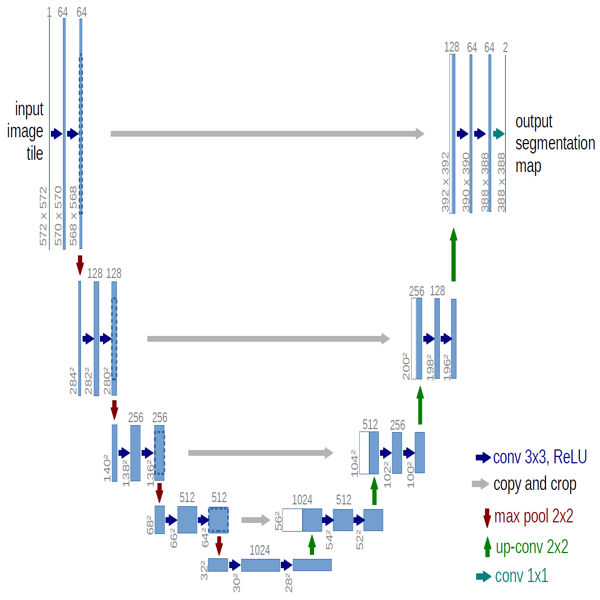

In [3]:
path_to_image = '../data/u-net-architecture.png'
new_size = (600, 600)  # Измените размеры по вашему усмотрению
original_image = Image.open(path_to_image)
resized_image = original_image.resize(new_size)
display(resized_image)

In [102]:
class UNet(pl.LightningModule):
    def __init__(self, n_class=2):
        super().__init__()
        self.loss_function = nn.BCEWithLogitsLoss()
        # Encoder
        # input_image_shape: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input_image_shape: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input_image_shape: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input_image_shape: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input_image_shape: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)
        return out
    
    def training_step(self, train_batch, batch_idx):
        images, labels = train_batch
        outputs = self(images)
        outputs = outputs.cpu()
        labels = labels.cpu()
        loss, dice, bce = self.calculate_loss(outputs, labels)
        metrics = {'train_loss_bce': bce, 'train_loss_dice': dice}
        self.log_dict(metrics, prog_bar=True, logger=True)
        return {'loss': loss}

    def validation_step(self, val_batch, batch_idx):
        images, labels = val_batch
        outputs = self(images)
        outputs = outputs.cpu()
        labels = labels.cpu()
        loss, dice, bce = self.calculate_loss(outputs, labels)
        metrics = {'val_loss_bce': bce, 'val_loss_dice': dice}
        self.log_dict(metrics, prog_bar=True, logger=True)

    # def test_step(self, test_batch, batch_idx):
    #     images, labels = test_batch
    #     outputs = self(images)
    #     loss = self.loss_function(outputs, labels)
    #     self.log('test_loss', loss, prog_bar=True)
        
    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
      return optimizer

    @staticmethod
    def dice_loss(output, target, smooth=1., predict=False):
        if predict:
            intersection = (output * target).sum(dim=1).sum(dim=1)

            loss = (1 - ((2. * intersection + smooth) / (
                    output.sum(dim=1).sum(dim=1) + target.sum(dim=1).sum(dim=1) + smooth)))
            return loss.mean()
        else:
            intersection = (output * target).sum(dim=2).sum(dim=2)

            loss = (1 - ((2. * intersection + smooth) / (
                        output.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
        
        return loss.mean()
     
    # def calculate_loss(self, pred, target, bce_weight=0.5):
    #     bce = self.loss_function(pred, target)
    #     pred = torch.sigmoid(pred)
    #     dice = UNet.dice_loss(pred, target)
    #     return bce, dice

    def calculate_loss(self, pred, target, weight_contour=1.0):
        mask_target = target[:, 0, :, :].unsqueeze(1)

        # print(mask_target.shape)
        contour_target = target[:, 1, :, :].unsqueeze(1)
        # print(contour_target.shape)
        loss_function = nn.BCEWithLogitsLoss()
        
        bce_mask = loss_function(pred[:, 0, :, :].unsqueeze(1), mask_target)
        bce_contour = loss_function(pred[:, 1, :, :].unsqueeze(1), contour_target)
        
        pred_sigmoid = torch.sigmoid(pred)
        dice_mask = UNet.dice_loss(pred_sigmoid[:, 0, :, :].unsqueeze(1), mask_target)
        dice_contour = UNet.dice_loss(pred_sigmoid[:, 1, :, :].unsqueeze(1), contour_target)
    
        # total_loss = bce_mask + dice_mask + weight_contour * (bce_contour + dice_contour)
        # total_loss = bce_mask + weight_contour * bce_contour
        total_loss = bce_mask
        bce = (bce_mask, bce_contour)
        dice = (dice_mask, dice_contour)
        return total_loss, dice, bce
    


<!-- Train -->

In [ ]:
Training

In [16]:
data_module = UnetDataModule(data_dir='../data/generated/base_df')
data_module.setup(stage='fit')
model = UNet(1)
tb_logger = pl_loggers.TensorBoardLogger(name='U-Net_Dyson_Logits', save_dir="log/")

trainer = pl.Trainer(accelerator="gpu", logger=tb_logger, max_epochs=3)
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: U_Net_BCE_Logits_2_checkpoint.ckpt\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type              | Params
-----------------------------------------------------
0  | loss_function | BCEWithLogitsLoss | 0     
1  | e11           | Conv2d            | 1.8 K 
2  | e12           | Conv2d            | 36.9 K
3  | pool1         | MaxPool2d         | 0     
4  | e21           | Conv2d            | 73.9 K
5  | e22           | C

Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

In [ ]:
ckpt_path = 'logs/U-Net_BCE_Logits/version_3/checkpoints/epoch=9-step=12730.ckpt'
model = UNet.load_from_checkpoint(ckpt_path=ckpt_path)
data_module = UnetDataModule(data_dir='../data/generated/')
data_module.setup(stage='test')
test_dataset = data_module.test_dataset
test_dataloader = DataLoader(test_dataset, batch_size=4)
trainer = pl.Trainer()
trainer.test(model, dataloaders=test_dataloader)

In [ ]:
Show predicted_mask

In [ ]:
model = UNet.load_from_checkpoint(ckpt_path=ckpt_path)
data_module = UnetDataModule(data_dir='../data/generated/')
data_module.setup(stage='test')
test_dataset = data_module.test_dataset
test_dataloader = DataLoader(test_dataset, batch_size=4)
model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        predicted_masks = (outputs > 0.5).float()
        predicted_masks = predicted_masks[0].permute(1, 2, 0)
        plt.imshow(predicted_masks.cpu().numpy(), cmap='gray')

## Улучшение предсказаний

In [16]:
# Вытаскиваем плохие маски
ckpt_path = 'log/U-Net_Dyson_Logits/version_4/checkpoints/epoch=9-step=9550.ckpt'
unet = UNet(1)
model = UNet.load_from_checkpoint(checkpoint_path=ckpt_path)
data_module = UnetDataModule(data_dir='../data/generated/')
data_module.setup(stage='test')
test_dataset = data_module.test_dataset
test_dataloader = DataLoader(test_dataset, batch_size=4)
model.eval()
bad_loss = []
with torch.no_grad():
        for count, batch in enumerate(test_dataloader):
            images, labels = batch
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            for output, label, image in zip(outputs, labels, images):
                loss = UNet.dice_loss(output=output, target=label, predict=True)
                if loss > 0.1:
                    bad_loss.append((count, loss, image, label, output))        

In [10]:
print(bad_loss[0][0])
print(bad_loss[0][1])
test_df = pd.read_csv('../data/generated/test_df.csv')
bad_contur = test_df[0:4]['object']
bad_contur

0
tensor(0.0494, device='cuda:0')


0    ../data/generated/resized_images\person1440_ba...
1    ../data/generated/resized_images\person1010_vi...
2        ../data/generated/resized_images\d6494b39.jpg
3    ../data/generated/resized_images\person1590_ba...
Name: object, dtype: object

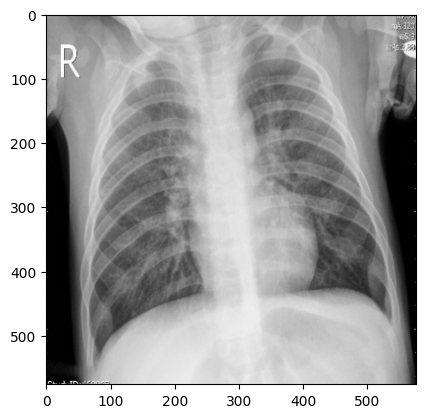

In [9]:
img = bad_loss[0][2]
label = bad_loss[0][3]
mask = bad_loss[0][4]
predicted_masks = (mask > 0.5).float()
image = img.permute(1, 2, 0)  # Assuming the input is in the shape (C, H, W)
predicted_masks = predicted_masks.permute(1, 2, 0)
plt.imshow(image.cpu().numpy())

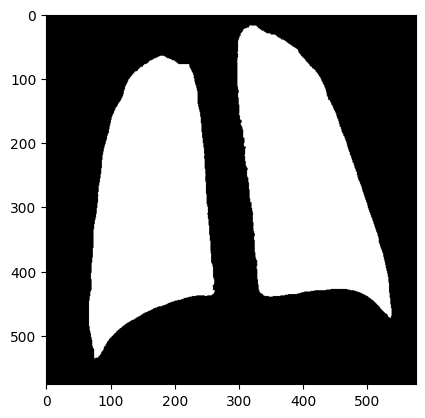

In [9]:
plt.imshow(predicted_masks.cpu().numpy(), cmap='gray')

In [7]:
# Накладываем контуры на маски

def resize_keypoints(keypoints, original_size, target_size = (572, 572)):
    scale_x = target_size[1] / int(original_size[1])
    scale_y = target_size[0] / int(original_size[0])

    resized_keypoints = []

    for point in keypoints:
        x = int(point[1] * scale_x)
        y = int(point[0] * scale_y)
        resized_keypoints.append((y, x))

    return resized_keypoints


def visualize_mask_with_contur(file_path, mask): 
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    
    left_lung = [[point['x'], point['y']] for point in data['annotations'][0]['polygon']['path']]
    left_lung = resize_keypoints(left_lung, (data['image']['width'],data['image']['height']) )
    right_lung = [[point['x'], point['y']] for point in data['annotations'][1]['polygon']['path']]
    right_lung = resize_keypoints(right_lung, (data['image']['width'],data['image']['height']) )


    left_polygon = Polygon(left_lung)
    right_polygon = Polygon(right_lung)
    
    plt.imshow(mask, cmap='gray')
    
    x, y = left_polygon.exterior.xy
    plt.plot(x, y, color='r', linewidth=1)
    
    
    x, y = right_polygon.exterior.xy
    plt.plot(x, y, color='r', linewidth=1)


json_path = '../data/all-images/annotations/person1440_bacteria_3723.json' 
mask = predicted_masks.cpu().numpy()
visualize_mask_with_contur(json_path, mask)

## Добавление контуров в датасеты

In [18]:
image_folder = '../data/images/'
annotations_path = '../data/all-images/annotations/'
dataset = get_DataSet(image_folder, annotations_path)

In [90]:
#  Создаем новый датафрейм, в котором дополнительно будут храниться контуры легких по отдельности(np.array формат)
def create_contur_numpy_df(df, img_folder = '../data/images', mask_folder = '../data/generated/masks', contur_folder = '../data/generated/np_conturs'  ):
    for num, mask_name in zip(range(len(dataset)), os.listdir(mask_folder)):
        _, lungs, img_name = dataset[num]
        img_path = os.path.join(img_folder, img_name)
        mask_path = os.path.join(mask_folder, mask_name)
        left_contur_path, right_contur_path = save_contur(lungs, img_name, contur_folder)
        df.loc[num] = {'image_path' : img_path, 'mask_path' : mask_path, 'left_contur_path' : left_contur_path, 'right_contur_path' : right_contur_path }
    return df


def save_contur(lungs, img_name, contur_folder):
    left_contur, right_contur =  np.array(lungs['left_lung']),  np.array(lungs['right_lung'])
    left_contur_name = str(os.path.splitext(img_name)[0]) + 'left.npy'
    right_contur_name = str(os.path.splitext(img_name)[0]) + 'right.npy'
    left_contur_path =  os.path.join(contur_folder, left_contur_name)
    right_contur_path =  os.path.join(contur_folder, right_contur_name)
    np.save(left_contur_path, left_contur)
    np.save(right_contur_path, right_contur)
    return left_contur_path, right_contur_path


df_with_contur = pd.DataFrame(columns = ['image_path', 'mask_path', 'left_contur_path', 'right_contur_path'])
df_with_contur = create_contur_df(df_with_contur)

In [91]:
df_with_contur

,image_path,mask_path,left_contur_path,right_contur_path
0,../data/images\000001-12.jpg,../data/generated/masks\mask_000001-12.jpg,../data/generated/np_conturs\000001-12left.npy,../data/generated/np_conturs\000001-12right.npy
1,../data/images\000001-17.jpg,../data/generated/masks\mask_000001-17.jpg,../data/generated/np_conturs\000001-17left.npy,../data/generated/np_conturs\000001-17right.npy
2,../data/images\000001-19.jpg,../data/generated/masks\mask_000001-19.jpg,../data/generated/np_conturs\000001-19left.npy,../data/generated/np_conturs\000001-19right.npy
3,../data/images\000001-2.jpg,../data/generated/masks\mask_000001-2.jpg,../data/generated/np_conturs\000001-2left.npy,../data/generated/np_conturs\000001-2right.npy
4,../data/images\000001-24.jpg,../data/generated/masks\mask_000001-24.jpg,../data/generated/np_conturs\000001-24left.npy,../data/generated/np_conturs\000001-24right.npy
...,...,...,...,...
6360,../data/images\wong-0005.jpg,../data/generated/masks\mask_wong-0005.jpg,../data/generated/np_conturs\wong-0005left.npy,../data/generated/np_conturs\wong-0005right.npy
6361,../data/images\X-ray_of_cyst_in_pneumocystis_p...,../data/generated/masks\mask_X-ray_of_cyst_in_...,../data/generated/np_conturs\X-ray_of_cyst_in_...,../data/generated/np_conturs\X-ray_of_cyst_in_...
6362,../data/images\yxppt-2020-02-19_00-51-27_28721...,../data/generated/masks\mask_yxppt-2020-02-19_...,../data/generated/np_conturs\yxppt-2020-02-19_...,../data/generated/np_conturs\yxppt-2020-02-19_...
6363,../data/images\yxppt-2020-02-19_00-51-27_28721...,../data/generated/masks\mask_yxppt-2020-02-19_...,../data/generated/np_conturs\yxppt-2020-02-19_...,../data/generated/np_conturs\yxppt-2020-02-19_...


### Построение контуров и их сохранение

In [1]:
def resize_contour(image, left_contur, right_contur, new_size = (576, 576)):
        scale_x = new_size[1] / int(image.size[1])
        scale_y = new_size[0] / int(image.size[0])
        left_contur = left_contur * np.array([scale_y, scale_x])
        right_contur = right_contur * np.array([scale_y, scale_x])
        return left_contur, right_contur

def create_contur(conturs_folder = '../data/generated/conturs'):
    for img_path, left_lung_path, right_lung_path in zip(df_with_contur['image_path'],df_with_contur['left_contur_path'], df_with_contur['right_contur_path']):
        left_contur = np.load(left_lung_path) 
        right_contur = np.load(right_lung_path)
        img = Image.open(str(img_path)).convert('RGB')
        left_contur, right_contur = resize_contour(img, left_contur, right_contur)
        
        image_size = (576, 576)   # Создание пустого изображения с черным фоном
        contour_image = np.zeros(image_size, dtype=np.uint8)  # Черный фон
        
        plt.figure()
        ax = plt.gca()
        ax.set_axis_off()
        ax.imshow(contour_image, cmap='gray')
        
        left_polygon = plt_Polygon(left_contur, edgecolor='white', facecolor='none')
        ax.add_patch(left_polygon)
        
        right_polygon = plt_Polygon(right_contur, edgecolor='white', facecolor='none')
        ax.add_patch(right_polygon)

        conturs_file_name =  'contur_' + os.path.basename(img_path)
        conturs_path = os.path.join(conturs_folder, conturs_file_name)
        plt.savefig(conturs_path, bbox_inches='tight', pad_inches=0, transparent=True, dpi=300)
        plt.clf()


create_contur()

Создание нового датафрейма с колонками : ['image_path', 'mask_path', 'contur_path']

In [111]:
dataset = get_DataSet(image_folder, annotations_path)

def create_contur_path_df(df, img_folder='../data/images', mask_folder='../data/generated/masks', contur_folder='../data/generated/conturs'  ):
    for id, img_name, mask_name, contur_name in zip(range(len(dataset)), os.listdir(img_folder), os.listdir(mask_folder), os.listdir(contur_folder)):
        img_path = os.path.join(img_folder, img_name)
        mask_path = os.path.join(mask_folder, mask_name)
        contur_path = os.path.join(contur_folder, contur_name)
        df.loc[id] = {'image_path' : img_path, 'mask_path' : mask_path, 'contur_path' : contur_path, }
    return df

df_v2_contur = pd.DataFrame(columns = ['image_path', 'mask_path', 'contur_path'])   #v2 - означает, что будет использоваться в улучшенной UNet модели
df_v2_contur = create_contur_path_df(df_v2_contur)

In [121]:
df_v2_contur.to_csv('../data/generated/df_conturs/full_df.csv', index=False)

In [3]:
df_v2_contur = pd.read_csv('../data/generated/df_conturs/full_df.csv')

images = df_v2_contur['image_path']
masks = df_v2_contur['mask_path']
contur = df_v2_contur['contur_path']

images_train, images_test, mask_train, mask_test, contur_train, contur_test = train_test_split(images, masks, contur, test_size=0.2, train_size=0.8, random_state=42)
images_test, images_val, mask_test, mask_val, contur_test, contur_val = train_test_split(images_test, mask_test, contur_test, test_size=0.5, random_state=42)

train_contur_df = pd.DataFrame({'image' : images_train,
                                'mask' : mask_train,
                                'contur' : contur_train})
train_contur_df.to_csv('../data/generated/df_conturs/train_df.csv', index=False)

test_contur_df = pd.DataFrame({'image' : images_test,
                               'mask' : mask_test,
                               'contur' : contur_test})
test_contur_df.to_csv('../data/generated/df_conturs/test_df.csv', index=False)

val_contur_df =  pd.DataFrame({'image' : images_val,
                               'mask' : mask_val,
                               'contur' : contur_val})
val_contur_df.to_csv('../data/generated/df_conturs/val_df.csv', index=False)

print(f'counts:\n train_df - {len(images_train)},\n test_df {len(images_test)},\n val_df : {len(images_val)}')

counts:
 train_df - 5092,
 test_df 636,
 val_df : 637


In [49]:
train_df = pd.read_csv('../data/generated/df_conturs/train_df.csv')
# arr = arr.apply(lambda x: np.fromstring(x[1:-1], sep='\n', dtype=float))
transform = transforms.Compose([transforms.Resize((576, 576)), transforms.ToTensor()])
train_dataset = CustomDataset_with_Conturs(train_df, transform)
print(train_dataset[3][1].shape)
print(train_dataset[3][1])
mask_counts_ones = torch.sum(train_dataset[3][1][0] == 1).item()
contur_counts_ones = torch.sum(train_dataset[3][1][1] == 1).item()
print('кол-во единиц в маске ', mask_counts_ones, ', кол-во единиц в контуре ', contur_counts_ones)

torch.Size([2, 1, 576, 576])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
кол-во единиц в маске  82777 , кол-во единиц в контуре  38


torch.Size([1, 576, 576])


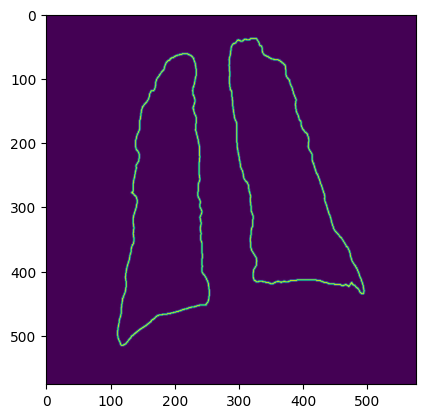

In [45]:
print(train_dataset[0][1][0].shape)
mask = train_dataset[0][1][1].permute(1, 2, 0)
plt.imshow(mask.cpu().numpy())


## Training with conturs

In [103]:
data_module = UnetDataModule(data_dir='../data/generated/df_conturs/')
data_module.setup(stage='fit', conturs=True)

model = UNet()
# tb_logger = pl_loggers.TensorBoardLogger(name='U-Net_Dyson_Logits', save_dir="log_conturs/")

trainer = pl.Trainer(accelerator="gpu", max_epochs=3)
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type              | Params
-----------------------------------------------------
0  | loss_function | BCEWithLogitsLoss | 0     
1  | e11           | Conv2d            | 1.8 K 
2  | e12           | Conv2d            | 36.9 K
3  | pool1         | MaxPool2d         | 0     
4  | e21           | Conv2d            | 73.9 K
5  | e22           | Conv2d            | 147 K 
6  | pool2         | MaxPool2d         | 0     
7  | e31           | Conv2d            | 295 K 
8  | e32           | Conv2d            | 590 K 
9  | pool3         | MaxPool2d         | 0     
10 | e41           | Conv2d            | 1.2 M 
11 | e42           | Conv2d            | 2.4 M 
12 | pool4         | MaxPool2d         | 0     
13 | e51           | Conv2d            | 4.7 M 
14 | e52           | Conv2d    

Sanity Checking: |                                                                               | 0/? [00:00<…

IndexError: index 1 is out of bounds for dimension 1 with size 1

In [98]:
# для тренировки без Pytorch ligthning
def calculate_loss(pred, target, weight_contour=1.0):
        mask_target = target[:, 0, :, :].unsqueeze(1)

        # print(mask_target.shape)
        contour_target = target[:, 1, :, :].unsqueeze(1)
        # print(contour_target.shape)
        loss_function = nn.BCEWithLogitsLoss()
        
        bce_mask = loss_function(pred[:, 0, :, :].unsqueeze(1), mask_target)
        bce_contour = loss_function(pred[:, 1, :, :].unsqueeze(1), contour_target)
        
        pred_sigmoid = torch.sigmoid(pred)
        dice_mask = UNet.dice_loss(pred_sigmoid[:, 0, :, :].unsqueeze(1), mask_target)
        dice_contour = UNet.dice_loss(pred_sigmoid[:, 1, :, :].unsqueeze(1), contour_target)
    
        # total_loss = bce_mask + dice_mask + weight_contour * (bce_contour + dice_contour)
        # total_loss = bce_mask + weight_contour * bce_contour
        total_loss = bce_mask
        bce = (bce_mask, bce_contour)
        dice = (dice_mask, dice_contour)
        return total_loss, dice, bce
    


In [101]:
model = UNet()

data_module = UnetDataModule(data_dir='../data/generated/df_conturs/')
data_module.setup(stage='fit', conturs=True)
train_dataloader = data_module.train_dataloader()
for batch in train_dataloader:
    images, targets = batch
    print('Target shape: ', targets.shape)
    outputs = model(images)
    loss, dice, bce = calculate_loss(outputs, targets)
    print(f"Batch Loss: {bce}")
    break

Target shape:  torch.Size([4, 2, 576, 576])
torch.Size([4, 1, 576, 576])
torch.Size([4, 1, 576, 576])
Batch Loss: (tensor(0.6791, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), tensor(0.6667, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>))
